# What factors influence points earned by wines

In [79]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

import seaborn as sns

In [3]:
wine = pd.read_csv('wine.csv')
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selecci√≥n Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodr√≠guez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La B√©gude, named af...",La Br√ªlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la B√©gude


### EDA

In [52]:
# What columns are we working with
wine.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'variety', 'winery'],
      dtype='object')

In [56]:
# We can drop unnamed, it seems to be a redundant index
wine = wine.drop('Unnamed: 0', axis=1)

In [58]:
wine.shape #--> 1103 observations

(1103, 10)

Text(0.5,1,'Observation counts by country')

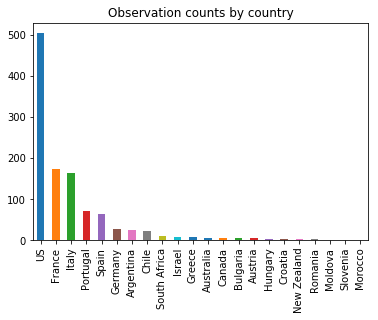

In [70]:
wine.country.value_counts().plot(kind='bar')
plt.title("Observation counts by country")

### Does country influence points?

C:\Users\Grant\Anaconda3_5\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


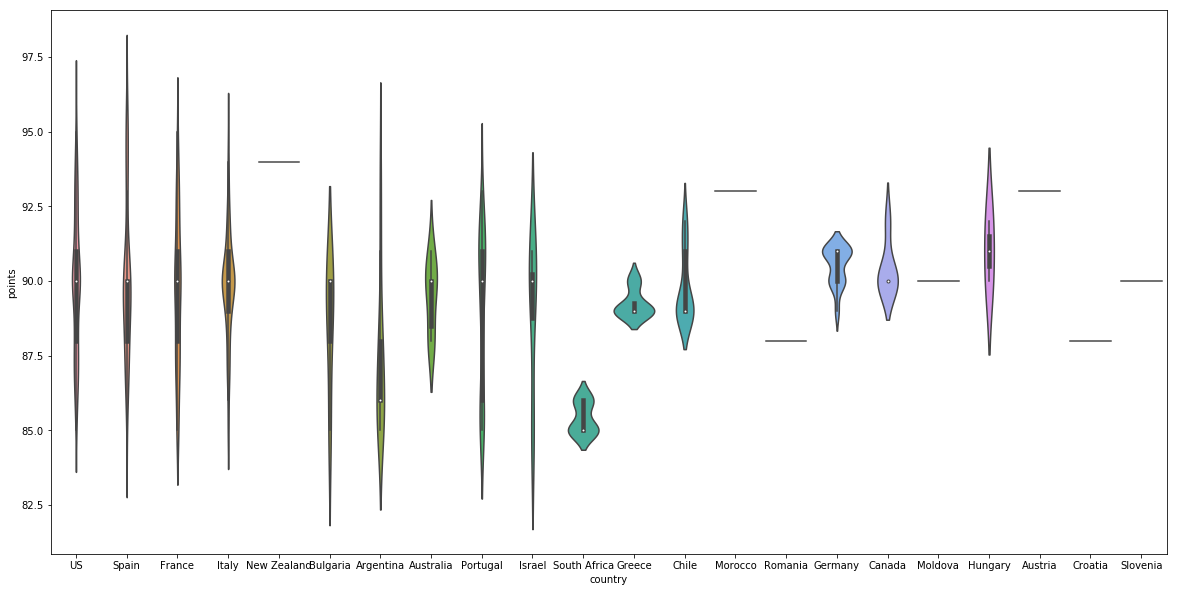

In [122]:
fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(x='country', y='points', data=wine)

The country of origin seems to have an influence on the points. Wines from South Africa generally have lower points than wines from Greece or Germany.

x

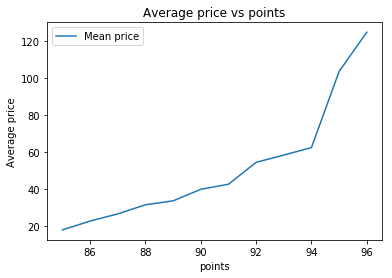

In [178]:
price_points = pd.DataFrame(wine.groupby('points')['price'].mean())
price_points.columns=['Mean price']
price_points.plot()
plt.ylabel("Average price")
plt.title("Average price vs points")
plt.show()

In [105]:
wine[['points','price']].corr()

,points,price
points,1.000000,0.437145
price,0.437145,1.000000


The price of wine has a positive correlation with the points it receives.

### Do certain varieties receive more points than others?

In [179]:
head = wine.variety.value_counts().head(20)
most_popular = wine[wine["variety"].isin(head.index)]

In [180]:
tail = wine.variety.value_counts().tail(20)
least_popular = wine[wine["variety"].isin(tail.index)]

In [181]:
m = most_popular.groupby('variety')['points'].mean()
m.values

array([88.33333333, 88.        , 89.94382022, 89.81553398, 88.9       ,
       88.2       , 90.2962963 , 90.828125  , 89.35714286, 89.41428571,
       89.83333333, 90.74509804, 89.52380952, 89.11428571, 88.41666667,
       89.8125    , 90.71428571, 89.84      , 88.55172414, 90.04347826])

In [182]:
l = least_popular.groupby('variety')['points'].mean()
l.values

array([92, 93, 88, 89, 90, 90, 86, 88, 90, 90, 91, 88, 90, 90, 86, 90, 92,
       93, 89, 90], dtype=int64)

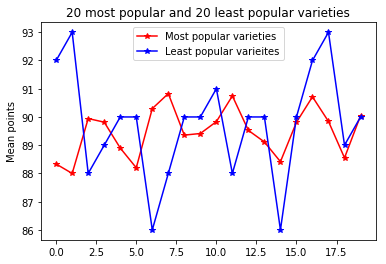

In [183]:
x = np.array(range(0,20))
plt.plot(x, m.values, marker="*", color="red")
plt.plot(x, l.values, marker="*", color="blue")
plt.legend(["Most popular varieties", "Least popular varieites"])
plt.ylabel("Mean points")
plt.title("20 most popular and 20 least popular varieties")
plt.show()

It doesn't appear that variety popularity plays a role in points.

### Imputation

In [187]:
# Missing values
wine.isnull().sum()

country          0
description      0
designation    269
points           0
price           57
province         0
region_1       173
region_2       611
variety          0
winery           0
dtype: int64

### Missing values in:

##### Designation:
Designation would be unique for every bottle of wine. It would not add value to assign a character string to each missing field in this column. I would not undertake imputation here.
##### Price:
Earlier in my EDA, it was noticed that price is positively correlated with points. Since points has no missing values, and since price is a continuous variable, the price could be inferred from points. I would undertake imputation.
How I would undertake imputation:
I would assign the mean price of all wines with the same number of points.  
##### Region_1 and region_2
Province is already an indicator of a region. If I wanted to analyse wines from regions within a province, then I would likely use these variables. Region_1 appears to be a subset of region_2 in cases where both are not missing. I may create a new variable which takes region_2 in the case where it is not missing and region_1 otherwise. For cases where both values are missing I would re-assess whether it would be better to impute a region or drop these observations.
How I would undertake this:
Calculate the mean price of the observations for each known region. If there is a significant statistical difference between the regions I would use the price of a wine to impute the region it is from. If there is no significant difference I would drop the observations with no known region.

### Do missing values greatly affect EDA?

With regards to Designation - no. I don't believe that knowing the unique designation of each wine would add any more value to my analysis.
With regards to price - no. I believe there was sufficient data (only 57/1103 observation were missing = 5%) to paint a clear picture of what was going on. I don't believe that knowing the extra 5% would greatly impact the positive relationship between price and points.
With regards to regions - I believe it may limit certain analyses. If I was to analyse wines within provinces, then a large lack of regional information may not allow me to paint a clear picture of what is going on within a particular province. For cases where only a handful of observations have missing regions - i.e. both missing region_1 and region_2 - this won't be a big problem as these can be dropped without losing too much info. 

### Word Cloud

In [40]:
province_counts = pd.value_counts(wine.province).to_frame().reset_index()
province_counts.head()

,index,province
0,California,350
1,Oregon,77
2,Tuscany,67
3,Piedmont,58
4,Washington,48


In [26]:
provinces = {}
for key, x in province_counts.values:
    provinces[key] = x

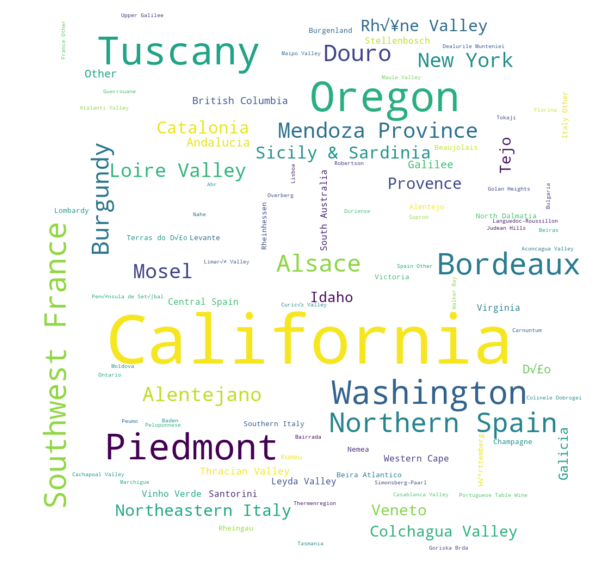

In [270]:
plt.figure(figsize=(20,10))
wordcloud = WordCloud(width=1000, height=1000, background_color="white").generate_from_frequencies(provinces)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
variety_counts = pd.value_counts(wine.variety).to_frame().reset_index()
variety_counts.head()

,index,variety
0,Pinot Noir,128
1,Chardonnay,103
2,Cabernet Sauvignon,89
3,Red Blend,70
4,Nebbiolo,54


In [49]:
varieties = {}
for key, x in variety_counts.values:
    varieties[key] = x

In [218]:
from PIL import Image
from wordcloud import STOPWORDS, ImageColorGenerator
mask = np.array(Image.open("wine_bottle.png"))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [212]:
# Transform mask function
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [202]:
transformed_wine_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

for i in range(len(mask)):
    transformed_wine_mask[i] = list(map(transform_format, mask[i]))

transformed_wine_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

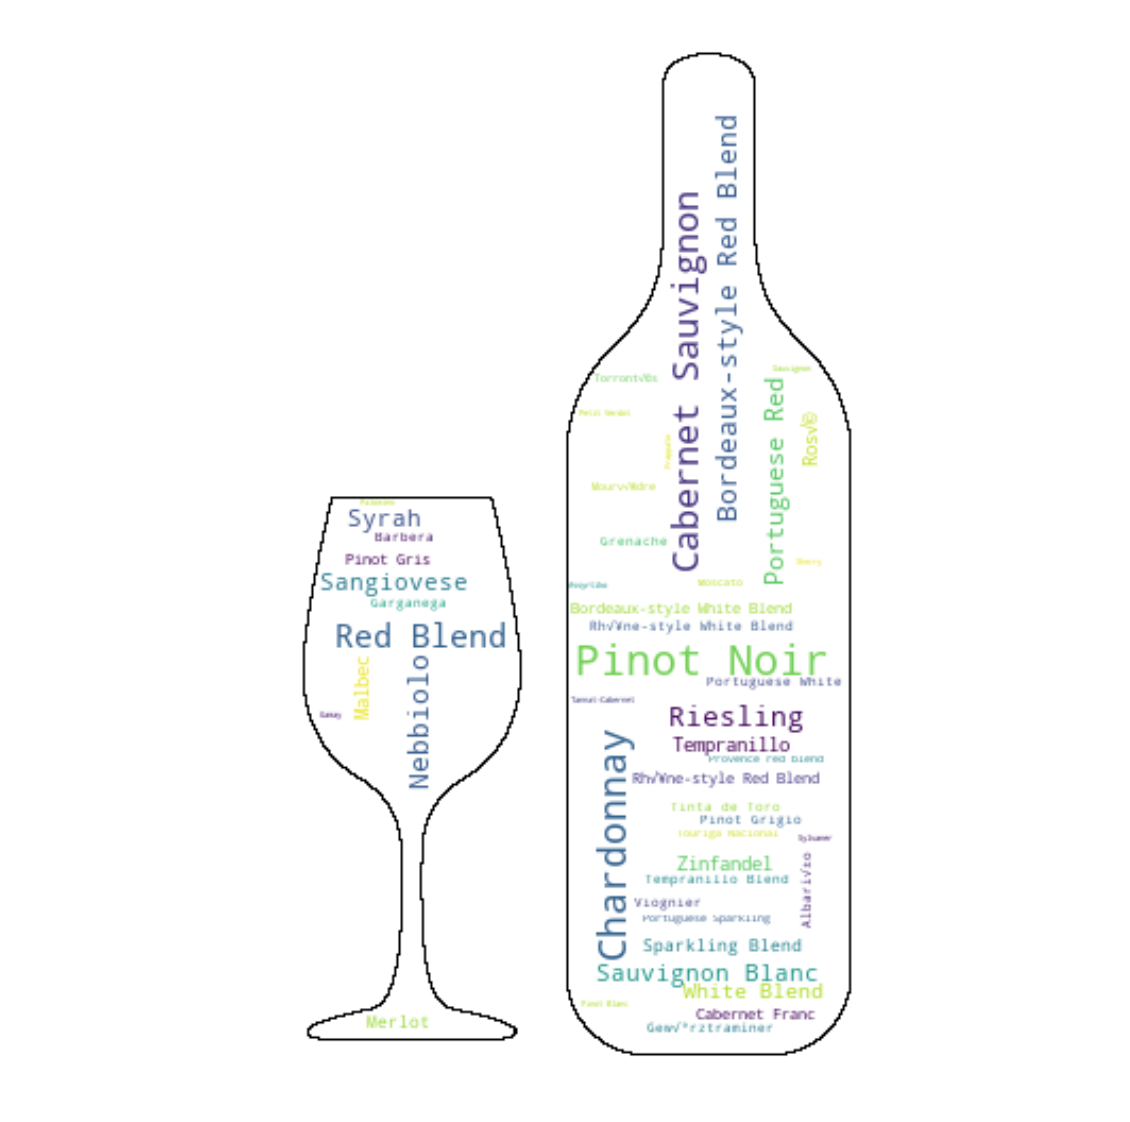

In [208]:
plt.figure(figsize=(20,20))
wordcloud = WordCloud(width=1000, height=1000, background_color="white", mask=transformed_wine_mask,
                     contour_width=1, contour_color="black").generate_from_frequencies(varieties)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()